# Multilabel

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
sys.path.append('..')
from weights import RidgeRegressor, Diffusion
from dataloader import MULANLoader, FoldsGenerator
from multilabel import DF, IL

In [3]:
np.random.seed(0)

### Choose datasets to play with

In [12]:
names = ['birds', 'CAL500', 'emotions', 'flags', 'genbase', 'medical', 'scene']
names = ['emotions', 'flags']

### Choose hyparameters for the simulations

In [13]:
kernel_type = 'Gaussian'
skewed = False
# skewed = True
nb_folds = 8
corruptions = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
# corruptions = [0]
sigmas = [.3, .1, .05]
lambdas = [1e3, 1e1, 1e-1]
mus = [1e3, 1e1, 1e-1, 1e-3]

# sigmas = [.3]
# lambdas = [1]
# mus = [1]

In [14]:
kernel_reg = Diffusion(sigma=1)

err_df, err_il = {}, {}
shape_err = (len(corruptions), nb_folds, len(sigmas), len(mus), len(lambdas))

for name in names:
    print(name)
    
    loader = MULANLoader(name)
    x, y = loader.get_trainset()
    
    ind = y.sum(axis=0) != 0
    y = y[:, ind]
    k = int(np.sum(y == 1, axis=1).mean()) + 1
#     k = int(np.sum(y == 1, axis=1).mean()) 

    met_df, met_il = DF(kernel_reg, k), IL(kernel_reg, k)
    err_df[name], err_il[name] = np.empty(shape_err), np.empty(shape_err)

    S = np.empty((*y.shape, len(corruptions)))
    for i_c, corruption in enumerate(corruptions):
        S[..., i_c] = loader.synthetic_corruption(y, corruption, skewed=skewed)
        
    floader = FoldsGenerator(x, y, S, nb_folds=nb_folds)
    for fold in range(nb_folds):
        (x_train, S_trains), (x_test, y_test) = floader()
        kernel_reg.set_support(x_train)
        n_train, dim = x_train.shape

        for i_s, c_sigma in enumerate(sigmas):
            sigma = c_sigma * dim
            kernel_reg.update_sigma(sigma, p=100)

            for i_m, c_mu in enumerate(mus):
                mu = c_mu / np.sqrt(n_train)
                kernel_reg.update_mu(mu=mu)
                
                for i_l, c_lambda in enumerate(lambdas):
                    lambd = c_lambda / (n_train ** (1/4))
                    psi = lambda x: (x+lambd)**(-1)
                    kernel_reg.update_psi(psi=psi)
                    alpha_train = kernel_reg(x_train)
                    alpha = kernel_reg(x_test)

                    for i_c, corruption in enumerate(corruptions):
                        S_train = S_trains[..., i_c]
                        y_dis = met_df.disambiguation(alpha_train, S_train, k)
                        pred_df = alpha @ y_dis
                        pred_il = alpha @ S_train

                        for pred in [pred_df, pred_il]:
                            idx = np.argsort(pred, axis=1)[:, -k:]
                            pred[:] = -1
                            met_il.fill_topk_pred(pred, idx)

                        err_df[name][i_c, fold, i_s, i_m, i_l] = ((pred_df - y_test) != 0).mean()
                        err_il[name][i_c, fold, i_s, i_m, i_l] = ((pred_il - y_test) != 0).mean()
            print(end='.')

emotions
........................flags
........................

In [15]:
kernel_reg = RidgeRegressor(kernel_type, sigma=1)

_err_df, _err_il = {}, {}
shape_err = (len(corruptions), nb_folds, len(sigmas), len(lambdas))

for name in names:
    print(name)
    
    loader = MULANLoader(name)
    x, y = loader.get_trainset()
    
    ind = y.sum(axis=0) != 0
    y = y[:, ind]
    k = int(np.sum(y == 1, axis=1).mean()) + 1
#     k = int(np.sum(y == 1, axis=1).mean()) 

    met_df, met_il = DF(kernel_reg, k), IL(kernel_reg, k)
    _err_df[name], _err_il[name] = np.empty(shape_err), np.empty(shape_err)

    S = np.empty((*y.shape, len(corruptions)))
    for i_c, corruption in enumerate(corruptions):
        S[..., i_c] = loader.synthetic_corruption(y, corruption, skewed=skewed)
        
    floader = FoldsGenerator(x, y, S, nb_folds=nb_folds)
    for fold in range(nb_folds):
        (x_train, S_trains), (x_test, y_test) = floader()
        kernel_reg.set_support(x_train)
        n_train, dim = x_train.shape

        for i_s, c_sigma in enumerate(sigmas):
            sigma = c_sigma * dim
            kernel_reg.update_sigma(sigma)

            for i_l, c_lambda in enumerate(lambdas):
                lambd = c_lambda / np.sqrt(n_train)
                kernel_reg.update_lambda(lambd)
                alpha_train = kernel_reg(x_train)
                alpha = kernel_reg(x_test)

                for i_c, corruption in enumerate(corruptions):
                    S_train = S_trains[..., i_c]
                    y_dis = met_df.disambiguation(alpha_train, S_train, k)
                    pred_df = alpha @ y_dis
                    pred_il = alpha @ S_train

                    for pred in [pred_df, pred_il]:
                        idx = np.argsort(pred, axis=1)[:, -k:]
                        pred[:] = -1
                        met_il.fill_topk_pred(pred, idx)

                    _err_df[name][i_c, fold, i_s, i_l] = ((pred_df - y_test) != 0).mean()
                    _err_il[name][i_c, fold, i_s, i_l] = ((pred_il - y_test) != 0).mean()
            print(end='.')

emotions
........................flags
........................

### Show results

In [16]:
mus = np.empty((len(names), 4, len(corruptions)))
stds = np.empty((len(names), 4, len(corruptions)))
best_lambdas = np.empty((len(names), 4, len(corruptions)))
best_sigmas = np.empty((len(names), 4, len(corruptions)))

for i, name in enumerate(names):
    for j, err in zip([0, 1, 2, 3], [err_df, err_il, _err_df, _err_il]):
        tmp = err[name].reshape(len(corruptions), nb_folds, -1)
        mu = tmp.mean(axis=1)
        ind = mu.argmin(axis=-1)
        for k in range(len(ind)):
            mus[i, j, k] = mu[k, ind[k]]
            stds[i, j, k] = tmp[k, :, ind[k]].std()            
#             best_lambdas[i, j, k] = lambdas[ind[k] % len(lambdas)]
#             best_sigmas[i, j, k] = sigmas[ind[k] // len(lambdas)]

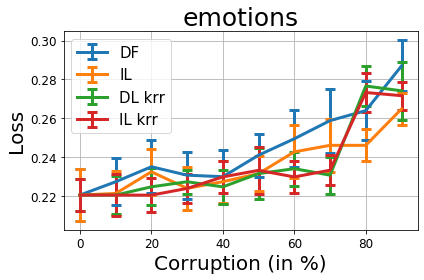

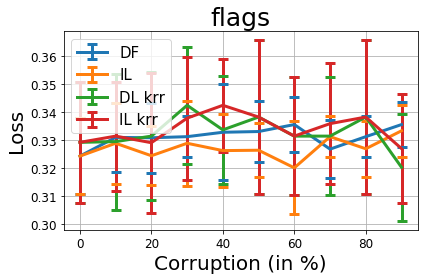

In [17]:
j = -1
for i, name in enumerate(names):
    fig, ax = plt.subplots()
    a = ax.errorbar([100*i for i in corruptions[:j]], mus[i, 0][:j], .5*stds[i, 0][:j], capsize=5, linewidth=3, capthick=3)
    b = ax.errorbar([100*i for i in corruptions[:j]], mus[i, 1][:j], .5*stds[i, 1][:j], capsize=5, linewidth=3, capthick=3)
    c = ax.errorbar([100*i for i in corruptions[:j]], mus[i, 2][:j], .5*stds[i, 2][:j], capsize=5, linewidth=3, capthick=3)
    d = ax.errorbar([100*i for i in corruptions[:j]], mus[i, 3][:j], .5*stds[i, 3][:j], capsize=5, linewidth=3, capthick=3)
#     a = ax.errorbar([100*i for i in corruptions[:-1]], mus[i, 0][:-1], .5*stds[i, 0][:-1], capsize=5, linewidth=3, capthick=3)
#     b = ax.errorbar([100*i for i in corruptions[:-1]], mus[i, 1][:-1], .5*stds[i, 1][:-1], capsize=5, linewidth=3, capthick=3)
    ax.legend([a, b, c, d], ['DF', "IL", 'DL krr', 'IL krr'], prop={'size':15})
    ax.grid()
    ax.set_title(name, size=25)
    ax.set_ylabel('Loss', size=20)
    ax.set_xlabel('Corruption (in %)', size=20)
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()
    fig.savefig(os.path.join('savings', 'ml', name + {True: '_skewed', False:''}[skewed] + '.pdf'))

## One shot test

In [10]:
def get_err_tt(name):
    loader = MULANLoader(name)
    x_train, y_train = loader.get_trainset()
    x_test, y_test = loader.get_testset()

    ind = y_train.sum(axis=0) != 0
    y_train = y_train[:, ind]
    y_test = y_test[:, ind]
    k = int(np.sum(y_train == 1, axis=1).mean()) + 1
    print(k)
    n_train, dim = x_train.shape

    err_df, err_il = np.empty(len(corruptions)), np.empty(len(corruptions))

    rand_corruption = np.random.rand(*y_train.shape)
    for i_c, corruption in enumerate(corruptions):
        S_train = y_train.copy()
        if skewed:
            S_train = (y_train + 1) / 2
        else:
            S_train = y_train.copy()
        ind = rand_corruption < corruption
        S_train[ind] = 0

        sigma_df, lambda_df = .1, 1e-2
        kernel = RidgeRegressor(kernel_type, sigma=sigma_df * dim)
        met_df = DF(kernel, k)

        sigma_il, lambda_il = .1, 1e-1
        kernel = RidgeRegressor(kernel_type, sigma=sigma_il * dim)
        met_il = IL(kernel, k)

        met_df.train(x_train, S_train, lambd=lambda_df / np.sqrt(n_train))
        met_il.train(x_train, S_train, lambd=lambda_il / np.sqrt(n_train))

        pred_df = met_df(x_test)
        pred_il = met_il(x_test)

#         print(pred_df == pred_il)
        
        err_df[i_c] = ((pred_df - y_test) != 0).mean()
        err_il[i_c] = ((pred_il - y_test) != 0).mean()
        print(end='.')
        
    return err_df, err_il

2
...........27
...........

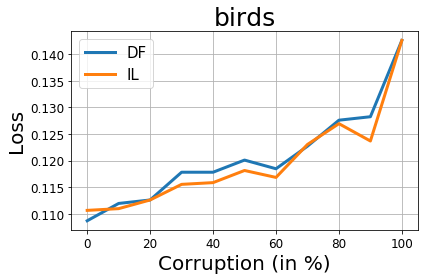

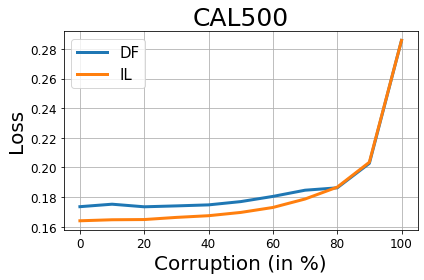

In [11]:
for i, name in enumerate(names):
    err_df, err_il = get_err_tt(name)
    fig, ax = plt.subplots()
    a, = ax.plot([100*i for i in corruptions[:]], err_df, linewidth=3)
    b, = ax.plot([100*i for i in corruptions[:]], err_il, linewidth=3)
    ax.legend([a, b], ['DF', "IL"], prop={'size':15})
    ax.grid()
    ax.set_title(name, size=25)
    ax.set_ylabel('Loss', size=20)
    ax.set_xlabel('Corruption (in %)', size=20)
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()
    fig.savefig(os.path.join('savings', 'ml', 'tt' + name + {True: '_skewed', False:''}[skewed] + '.pdf'))